In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, csv
matplotlib.style.use('seaborn-muted')

from matplotlib import *
from matplotlib import collections as mc
import seaborn as sns
import numpy as np
from adjustText import adjust_text
from scipy import stats
import statsmodels.stats as smstats
from statsmodels.stats.multitest import multipletests
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

base_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/Github_repo/'
figure_out_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/figures/'
sns.set_style('whitegrid')

## Identification of SREs in the ENCODE datasets ##

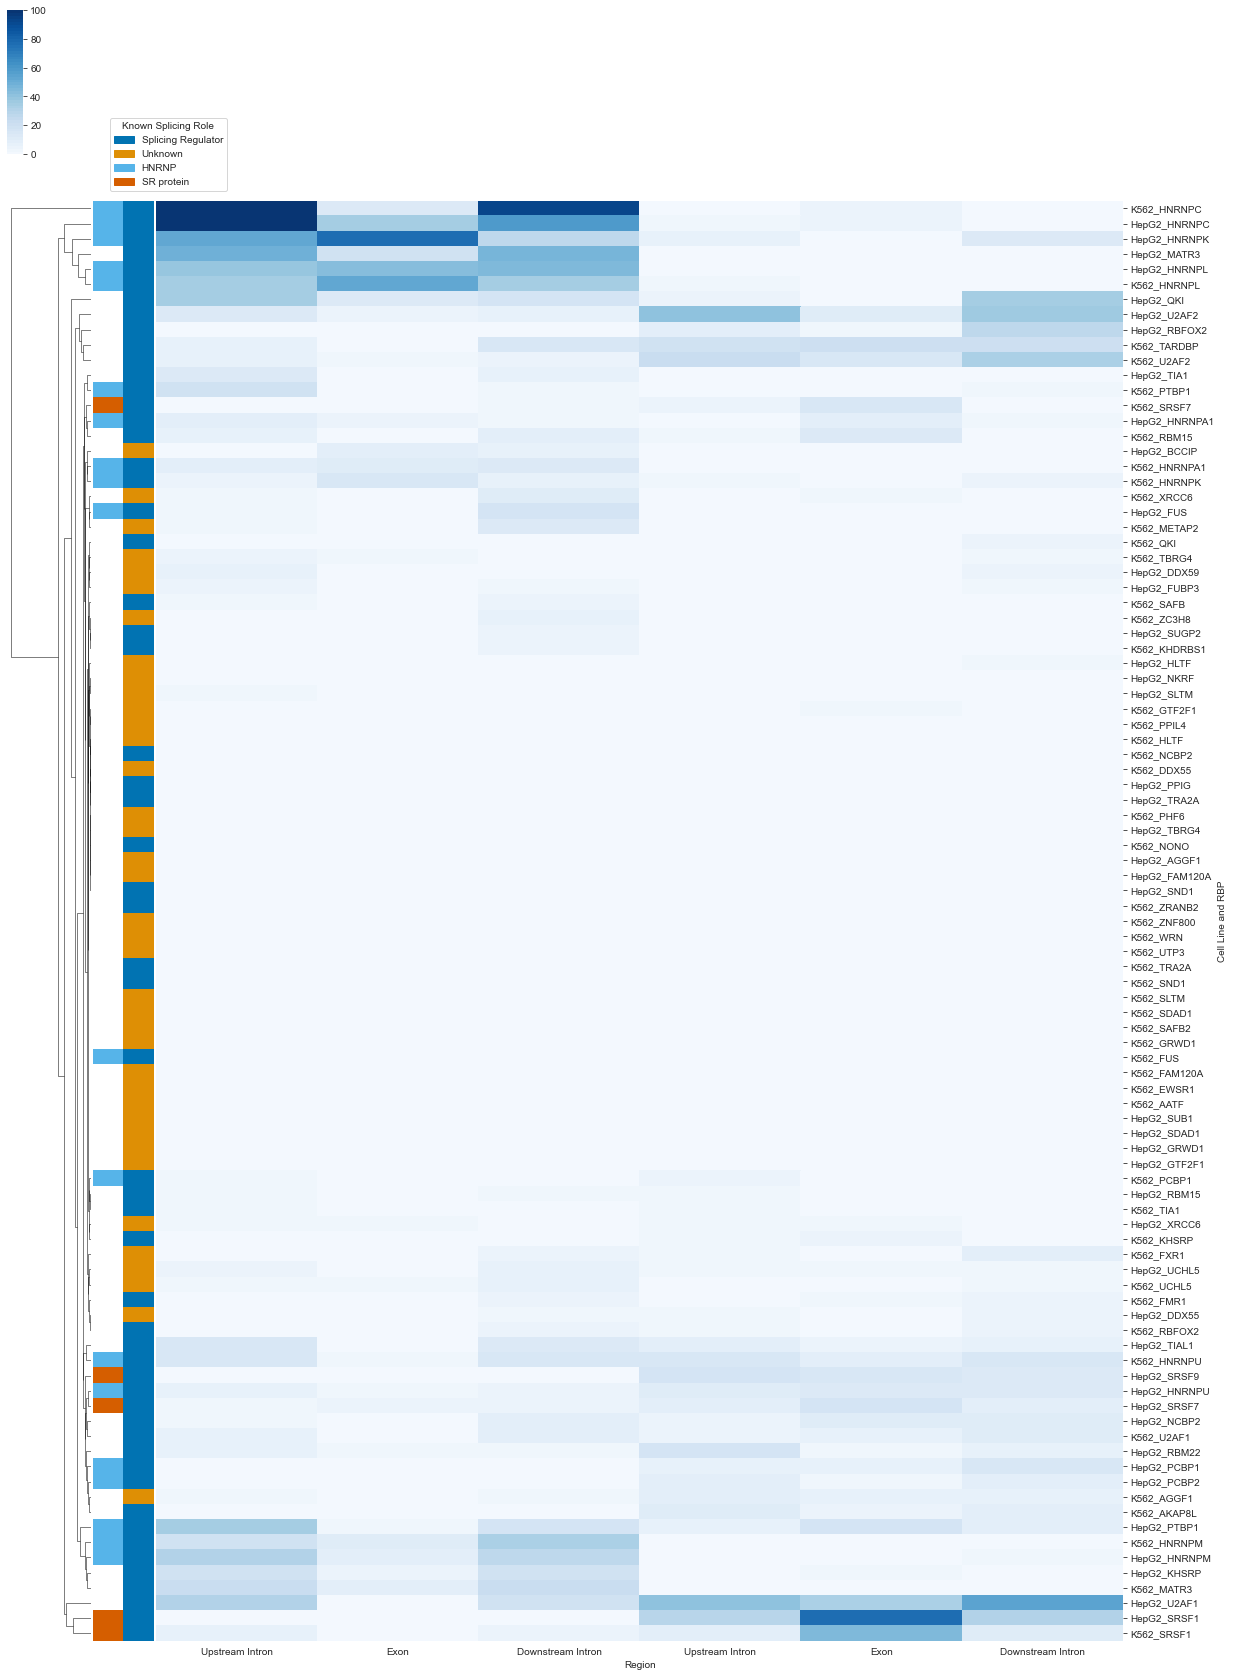

In [2]:
#previously ENCODE_data/SRE_classifier_unnormed.tsv
CLIP_splicing_int_df = pd.read_csv(base_dir + 'preprocessed_data/SRE_peaks_splicing_events.tsv', sep = '\t')

#the annotated splicing regulatory proteins are from Van Nostrand et al., 2020 (https://doi.org/10.1038) Supplementary Data 1
cell_line_RBPs = sorted(list(set(CLIP_splicing_int_df.loc[:,'cell_line_RBP'])))
annotated_SRPs = set(['AKAP8L', 'FMR1', 'FUS', 'HNRNPA1', 'HNRNPC', 'HNRNPK', 'HNRNPL', 'HNRNPM', 'HNRNPU', 'KHDRBS1', 'KHSRP', 'MATR3', 'NCBP2', 'NONO',
                      'PCBP1','PCBP2', 'PPIG', 'PTBP1', 'QKI', 'RBFOX2', 'RBM15', 'RBM22', 'SAFB', 'SND1', 'SRSF1', 'SRSF7', 'SRSF9', 'SUGP2', 'TARDBP',
                      'TIA1', 'TIAL1', 'TRA2A', 'ZRANB2', 'U2AF1', 'U2AF2'])
HNRNPs = ['HNRNPA1','HNRNPC', 'HNRNPK', 'HNRNPL', 'HNRNPM', 'HNRNPU','PTBP1', 'FUS', 'PCBP1', 'PCBP2']
SR_proteins = ['SRSF1', 'SRSF7','SRSF9']

functions = [];HNRNP_SRs = []
for cell_line_RBP in cell_line_RBPs:
    RBP = cell_line_RBP.split('_')[1]
    if RBP in annotated_SRPs: #these are just color sidebar codes
        functions.append((0.00392156862745098, 0.45098039215686275, 0.6980392156862745))
    else:
        functions.append((0.8705882352941177, 0.5607843137254902, 0.0196078431372549))
    if RBP in HNRNPs:
        HNRNP_SRs.append((0.33725490196078434, 0.7058823529411765, 0.9137254901960784))
    elif RBP in SR_proteins:
        HNRNP_SRs.append((0.8352941176470589, 0.3686274509803922, 0.0))
    else:
        HNRNP_SRs.append('white')

Splicing_regulatory_function = dict(zip(cell_line_RBPs, functions))
HNRNP_SRs = dict(zip(cell_line_RBPs, HNRNP_SRs))

def fishers_exact_test(row, test_type): #test significant overlap of binding and splicing regulation
    if test_type == 'silencer':
        try:
            odds_ratio, p_val = stats.fisher_exact(np.array([[row['up_peak'], row['up_no_peak']], [row['background_peak'], row['background_no_peak']]]),
                                           alternative = 'greater')
        except ValueError:
            p_val = np.nan; odds_ratio = 0
    if test_type == 'enhancer':
        try:
            odds_ratio, p_val = stats.fisher_exact(np.array([[row['down_peak'], row['down_no_peak']], [row['background_peak'], row['background_no_peak']]]),
                                           alternative = 'greater')
        except ValueError:
            p_val = np.nan;odds_ratio = 0
    return odds_ratio, p_val

def clip_NS(row):
    if 10**-row['silencer_fdr_p'] > 0.05:
        row['silencer_OR'] = 0
    if 10**-row['enhancer_fdr_p'] > 0.05:
        row['enhancer_OR'] = 0
    return row

legend_TN = [patches.Patch(color = (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
                           label = 'Splicing Regulator'),
             patches.Patch(color = (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), label = 'Unknown'),
             patches.Patch(color = (0.33725490196078434, 0.7058823529411765, 0.9137254901960784), label = 'HNRNP'),
             patches.Patch(color = (0.8352941176470589, 0.3686274509803922, 0.0), label = 'SR protein')]

CLIP_splicing_int_df = CLIP_splicing_int_df[CLIP_splicing_int_df.loc[:, 'peak_caller'] == 'iCount']

CLIP_splicing_int_df =CLIP_splicing_int_df.loc[:,('cell_line_RBP', 'region', 'up_peak', 'up_no_peak', 'down_peak', 'down_no_peak' ,'background_peak', 'background_no_peak')]

CLIP_splicing_int_df[['silencer_OR', 'silencer_p']] = CLIP_splicing_int_df.apply(fishers_exact_test, axis = 1, test_type = 'silencer', result_type = 'expand')
CLIP_splicing_int_df[['enhancer_OR', 'enhancer_p']] = CLIP_splicing_int_df.apply(fishers_exact_test, axis = 1, test_type = 'enhancer', result_type = 'expand')
CLIP_splicing_int_df = CLIP_splicing_int_df.fillna(1.0)
CLIP_splicing_int_df.sort_values('silencer_p')

CLIP_splicing_int_df['silencer_fdr_p'] = -np.log10(smstats.multitest.multipletests(CLIP_splicing_int_df.loc[:,'silencer_p'], method = 'bonferroni')[1])
CLIP_splicing_int_df['enhancer_fdr_p'] = -np.log10(smstats.multitest.multipletests(CLIP_splicing_int_df.loc[:,'enhancer_p'], method = 'bonferroni')[1])
CLIP_splicing_plot_df = CLIP_splicing_int_df
CLIP_splicing_plot_df = CLIP_splicing_plot_df.apply(clip_NS, axis = 1)

CLIP_splicing_plot_df = CLIP_splicing_plot_df.pivot(index = 'cell_line_RBP', columns = 'region', values =['silencer_fdr_p', 'enhancer_fdr_p'])

CLIP_splicing_plot_df = CLIP_splicing_plot_df.sort_index(axis=1, level=0, ascending=False, inplace=False,
                                                         kind='quicksort', na_position='last', sort_remaining=True)

g = sns.clustermap(CLIP_splicing_plot_df, col_cluster=False, figsize=(20, 30), row_colors = [CLIP_splicing_plot_df.index.map(HNRNP_SRs),
                                                                                             CLIP_splicing_plot_df.index.map(Splicing_regulatory_function)], 
                   cmap=sns.color_palette("Blues",50), metric ='euclidean',vmax = 100)
ax = g.ax_heatmap
ax.set_xlabel("Region")
ax.set_ylabel("Cell Line and RBP")
ax.set_xticklabels(['Upstream Intron', 'Exon', 'Downstream Intron', 'Upstream Intron', 'Exon', 'Downstream Intron'])
l2=g.cax.legend(loc='center',bbox_to_anchor=(10,0),handles=legend_TN,frameon=True)
l2.set_title(title='Known Splicing Role',prop={'size':10})

#plt.savefig(figure_out_dir + 'Figure_1A_SRE_heatmap_iCount.svg')

In [3]:
#how well does dependence of splicing changes and RBP binding identify splicing regulatory RBPs vs. RBPs without splicing regulatory function?
relevent_samples = []
for sample in Splicing_regulatory_function:
    if Splicing_regulatory_function[sample] == (0.00392156862745098, 0.45098039215686275, 0.6980392156862745):
        relevent_samples.append(sample)

SR_df = CLIP_splicing_plot_df[CLIP_splicing_plot_df.index.isin(relevent_samples)]
non_SR_df =CLIP_splicing_plot_df[CLIP_splicing_plot_df.index.isin(relevent_samples) == False]

threshold = 0.01

print('Percent annotated SRs with dependence: ', sum((10**-SR_df <= threshold).sum(axis=1) > 0) *100/ SR_df.shape[0])
print('Percent other with dependence: ', sum((10**-non_SR_df <= threshold).sum(axis=1) > 0) *100/ non_SR_df.shape[0])


Percent annotated SRs with dependence:  84.21052631578948
Percent other with dependence:  42.10526315789474


# Identifying factors influencing sensitive vs. robust splicing events #


In [4]:
#"Senstive" events are events that change splicing when a bound RBP is knocked down
#"Robust" events are events that don't change splicing when a bound RBP is knocked down
#Do sensitive events have weaker motifs relative to robust events

#read in RBPamp scores of peaks and 30 nts on each side of each peak
sens_robust_RBNS = pd.read_csv(base_dir + 'preprocessed_data/RBNS_peak_strength_sensitive_robust.tsv', sep ='\t')

samples = sorted(list(set(sens_robust_RBNS.loc[:,'sample'])))
print(samples)
pvalues = []; CLES = []; kept_samples = []
for sample in samples:
    #print(sample)
    plot_df = sens_robust_RBNS[sens_robust_RBNS.loc[:,'sample'] == sample]
    if plot_df[plot_df.loc[:,'status'] == 'sensitive'].shape[0] >= 10: #filter out datasets with fewer than 10 sensitive events
        kept_samples.append(sample)
        mwu = stats.mannwhitneyu(plot_df[plot_df.loc[:,'status'] == 'sensitive'].loc[:,'mean_score'],
                                 plot_df[plot_df.loc[:,'status'] == 'robust'].loc[:,'mean_score'], 
                                 alternative = 'two-sided')
        CLES.append(mwu[0]/(plot_df[plot_df.loc[:,'status'] == 'sensitive'].shape[0]*
                                  plot_df[plot_df.loc[:,'status'] == 'robust'].shape[0]))
        pvalues.append(mwu[1])

output_df_RBNS = pd.DataFrame({'sample': kept_samples, 'pvalue': pvalues, 'CLES': CLES, 'motif_type': 'RBNS'})

['HepG2_FUBP3', 'HepG2_FUS', 'HepG2_HNRNPA1', 'HepG2_HNRNPC', 'HepG2_HNRNPK', 'HepG2_HNRNPL', 'HepG2_KHSRP', 'HepG2_PCBP1', 'HepG2_PCBP2', 'HepG2_RBFOX2', 'HepG2_RBM22', 'HepG2_SRSF9', 'HepG2_TIA1', 'HepG2_TRA2A', 'K562_FUS', 'K562_HNRNPA1', 'K562_HNRNPC', 'K562_HNRNPK', 'K562_HNRNPL', 'K562_KHSRP', 'K562_PCBP1', 'K562_RBFOX2', 'K562_TARDBP', 'K562_TIA1', 'K562_TRA2A']


Text(0.5, 25.0, 'Common language effect size')

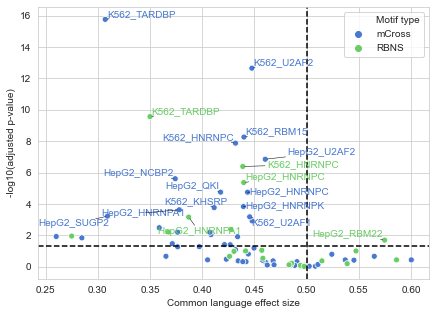

In [5]:
sens_robust_mCross = pd.read_csv(base_dir + 'preprocessed_data/mCross_scores_iCount.tsv.gz', sep ='\t')

samples = sorted(list(set(sens_robust_mCross.loc[:,'sample'])))
pvalues = []; CLES = []; kept_samples = [];best_matricies = {}
for sample in samples:
    plot_df = sens_robust_mCross[sens_robust_mCross.loc[:,'sample'] == sample]
    if plot_df[plot_df.loc[:,'status'] == 'sensitive'].shape[0] >= 10:
        kept_samples.append(sample)
        mwu = stats.mannwhitneyu(plot_df[plot_df.loc[:,'status'] == 'sensitive'].loc[:,'score'],
                                 plot_df[plot_df.loc[:,'status'] == 'robust'].loc[:,'score'],
                                     alternative = 'two-sided')
        pvalues.append(mwu[1])
        CLES.append(mwu[0]/(plot_df[plot_df.loc[:,'status'] == 'sensitive'].shape[0]*
                              plot_df[plot_df.loc[:,'status'] == 'robust'].shape[0]))

output_df_mCross = pd.DataFrame({'sample': kept_samples, 'pvalue': pvalues, 'CLES': CLES, 'motif_type':'mCross'})
output_df = pd.concat([output_df_mCross, output_df_RBNS])
output_df['corrected_pvalue'] = -np.log10(smstats.multitest.multipletests(output_df.loc[:,'pvalue'], method = 'fdr_bh')[1])
#sample 	pvalue 	CLES 	motif_type 	corrected_pvalue
output_df.columns = ['sample', 'pvalue', 'CLES', 'Motif type', 'corrected_pvalue']

fig, ax = plt.subplots(1,1,figsize = (7,5))
sns.scatterplot(x = 'CLES', y = 'corrected_pvalue', data = output_df, ax = ax, hue = 'Motif type')
ax.axhline(y = -np.log10(0.05), linestyle = '--', color = 'black')
ax.axvline(x = 0.5, linestyle = '--', color = 'black')
label_df = output_df[(output_df.loc[:,'corrected_pvalue'] >= -np.log10(0.001)) | 
                     ((output_df.loc[:,'corrected_pvalue'] >= -np.log10(0.05)) &(output_df.loc[:,'CLES']>0.5))]
texts = []
these_colors = sns.color_palette()[0:2]
for row in label_df.iterrows():
    row = row[1]
    if row['Motif type'] == 'mCross':
        color = these_colors[0]
    else:
        color = these_colors[1]
    texts.append(plt.text(x = row['CLES'], y = row['corrected_pvalue'], s = row['sample'],
                          color = color))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.ylabel('-log10(adjusted p-value)')
plt.xlabel('Common language effect size')

#plt.savefig(figure_out_dir + 'Figure_1B_motif_strength_volcano.svg')


1.0455276174041008e-11
0.3499103179567567


Text(0.5, 0, 'Exon status')

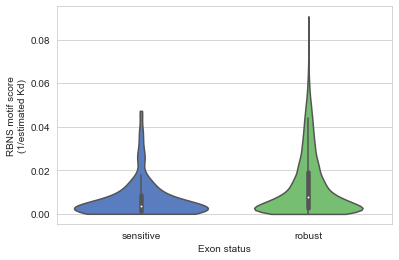

In [6]:
#example violinplot of univariate K562 TARDBP motif strength being weaker in sensitive peaks than robust ones
sample= 'K562_TARDBP'
plot_df = sens_robust_RBNS[sens_robust_RBNS.loc[:,'sample'] == sample]
kept_samples.append(sample)
mwu = stats.mannwhitneyu(plot_df[plot_df.loc[:,'status'] == 'sensitive'].loc[:,'mean_score'],
                         plot_df[plot_df.loc[:,'status'] == 'robust'].loc[:,'mean_score'],
                             alternative = 'two-sided')
print(mwu[1])
print(mwu[0]/(plot_df[plot_df.loc[:,'status'] == 'sensitive'].shape[0]* plot_df[plot_df.loc[:,'status'] == 'robust'].shape[0]))
sns.violinplot(x = 'status', y = 'mean_score', data = plot_df, cut = 0)
plt.ylabel('RBNS motif score\n(1/estimated Kd)')
plt.xlabel('Exon status')

Text(0.5, 25.0, 'Common language effect size')

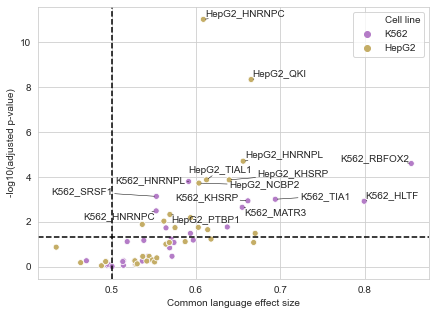

In [8]:
#Are sensitive events more likely to be regulated by multiple binding sites of the same RBP?
def self_peaks(row, RBP):
    this_dict = dict(zip(row['RBPs'].split(','), row['n_binding_sites'].split(',')))
    if RBP in this_dict:
        return int(this_dict[RBP])
    else:
        return np.nan

def check_KD_sensitivity(row, RBP):
    if isinstance(row['sensitive_events'], str) == True:
        if RBP in row['RBPs'].split(','):
            if RBP in row['sensitive_events'].split(','):
                return 'sensitive'
            else:
                return 'robust'

n_peaks = pd.DataFrame()
for cell_line in ['K562', 'HepG2']:
    n_peaks_df = pd.read_csv(base_dir + 'preprocessed_data/' + cell_line + '_rMATs_binding_summary_iCount.bed', sep ='\t')
    samples = set(np.concatenate(n_peaks_df.loc[:,'RBPs'].str.split(',')))
    pvalues = []; CLES = []; kept_samples = []
    for sample in samples:
        #print(sample)
        n_peaks_df['exon_status'] = n_peaks_df.apply(check_KD_sensitivity, axis = 1, RBP = sample)
        if n_peaks_df[n_peaks_df.loc[:,'exon_status'] == 'sensitive'].shape[0] >= 10:
            kept_samples.append(sample)
            this_df = n_peaks_df.copy().dropna()
            this_df['self_peaks'] = this_df.apply(self_peaks, axis = 1, RBP = sample)
            mwu = stats.mannwhitneyu(this_df[this_df.loc[:,'exon_status'] == 'sensitive'].loc[:,'self_peaks'],
                                     this_df[this_df.loc[:,'exon_status'] == 'robust'].loc[:,'self_peaks'], 
                                     alternative = 'two-sided')
            CLES.append(mwu[0]/(this_df[this_df.loc[:,'exon_status'] == 'sensitive'].shape[0]*
                                      this_df[this_df.loc[:,'exon_status'] == 'robust'].shape[0]))
            pvalues.append(mwu[1])
    output_df = pd.DataFrame({'sample': kept_samples, 'pvalue': pvalues, 'CLES': CLES, 'Cell line': cell_line})
    n_peaks = pd.concat([n_peaks, output_df])


n_peaks['corrected_pvalue'] = -np.log10(smstats.multitest.multipletests(n_peaks.loc[:,'pvalue'], method = 'fdr_bh')[1])

fig, ax = plt.subplots(1,1,figsize = (7,5))
sns.scatterplot(x = 'CLES', y = 'corrected_pvalue', data = n_peaks.dropna(), ax = ax, hue = 'Cell line', palette = sns.color_palette()[3:5])
ax.axhline(y = -np.log10(0.05), linestyle = '--', color = 'black')
ax.axvline(x = 0.5, linestyle = '--', color = 'black')


label_df = n_peaks[(n_peaks.loc[:,'corrected_pvalue'] >= -np.log10(0.005))]
texts = []
for row in label_df.iterrows():
    row = row[1]
    texts.append(plt.text(x = row['CLES'], y = row['corrected_pvalue'], s = row['sample']))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.ylabel('-log10(adjusted p-value)')
plt.xlabel('Common language effect size')
#plt.savefig(figure_out_dir + 'Figure_1C_self_binding_peaks_sens_robust_volcano.svg')

Text(0.5, 25.0, 'Common language effect size')

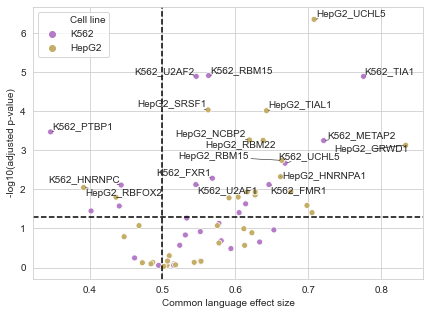

In [9]:
#Are sensitive events regulated by more RBPs than robust events?

n_peaks = pd.DataFrame()
for cell_line in ['K562', 'HepG2']:
    n_peaks_df = pd.read_csv(base_dir + 'preprocessed_data/' + cell_line + '_rMATs_binding_summary_iCount.bed', sep ='\t')
    samples = set(np.concatenate(n_peaks_df.loc[:,'RBPs'].str.split(',')))
    pvalues = []; CLES = []; kept_samples = []
    for sample in samples:
        n_peaks_df['exon_status'] = n_peaks_df.apply(check_KD_sensitivity, axis = 1, RBP = sample)
        if n_peaks_df[n_peaks_df.loc[:,'exon_status'] == 'sensitive'].shape[0] >= 10:
            kept_samples.append(sample)
            this_df = n_peaks_df.dropna()
            mwu = stats.mannwhitneyu(this_df[this_df.loc[:,'exon_status'] == 'sensitive'].loc[:,'n_RBPs'],
                                     this_df[this_df.loc[:,'exon_status'] == 'robust'].loc[:,'n_RBPs'], 
                                     alternative = 'two-sided')
            CLES.append(mwu[0]/(this_df[this_df.loc[:,'exon_status'] == 'sensitive'].shape[0]*
                                      this_df[this_df.loc[:,'exon_status'] == 'robust'].shape[0]))
            pvalues.append(mwu[1])
    output_df = pd.DataFrame({'sample': kept_samples, 'pvalue': pvalues, 'CLES': CLES, 'Cell line': cell_line})
    n_peaks = pd.concat([n_peaks, output_df])


n_peaks['corrected_pvalue'] = -np.log10(smstats.multitest.multipletests(n_peaks.loc[:,'pvalue'], method = 'fdr_bh')[1])

fig, ax = plt.subplots(1,1,figsize = (7,5))
sns.scatterplot(x = 'CLES', y = 'corrected_pvalue', data = n_peaks.dropna(), ax = ax, hue = 'Cell line', palette = sns.color_palette()[3:5])
ax.axhline(y = -np.log10(0.05), linestyle = '--', color = 'black')
ax.axvline(x = 0.5, linestyle = '--', color = 'black')

label_df = n_peaks[(n_peaks.loc[:,'corrected_pvalue'] >= -np.log10(0.01))]
texts = []
for row in label_df.iterrows():
    row = row[1]
    texts.append(plt.text(x = row['CLES'], y = row['corrected_pvalue'], s = row['sample']))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.legend(loc='upper left')


plt.ylabel('-log10(adjusted p-value)')
plt.xlabel('Common language effect size')
#plt.savefig(figure_out_dir + 'Figure_1D_nRBPs_sens_robust_volcano.svg')

(25, 5)


Text(0.5, 25.0, 'Common language effect size')

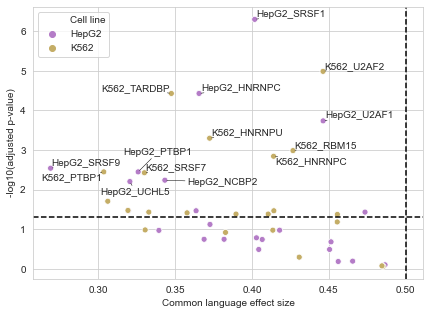

In [10]:
def sum_non_NA(row):
    total = []; junction_ids = []
    for col in ['intron_1_SE', 'intron_2_SE']:
        if np.isnan(row[col]) == False:
            junction_ids.append(row[col.replace('_SE', '_coors')])
            total.append(row[col])
    if total != []:
        return ';'.join(junction_ids), sum(total)/len(total)
    else:
        return ';'.join(junction_ids), np.nan

samples=sorted("""HepG2_DDX55 HepG2_DDX59 HepG2_FAM120A HepG2_FUBP3 HepG2_FUS HepG2_GRWD1 
HepG2_HLTF HepG2_HNRNPA1 HepG2_HNRNPC HepG2_HNRNPK HepG2_HNRNPL HepG2_HNRNPM HepG2_HNRNPU HepG2_KHSRP 
HepG2_MATR3 HepG2_NCBP2 HepG2_PCBP1 HepG2_PCBP2 HepG2_PPIG HepG2_PTBP1 HepG2_QKI HepG2_RBFOX2 
HepG2_RBM15 HepG2_SND1 HepG2_SRSF1 HepG2_SRSF7 HepG2_SRSF9 HepG2_TIA1 HepG2_TIAL1 HepG2_TRA2A HepG2_U2AF1 
HepG2_U2AF2 HepG2_UCHL5 HepG2_XRCC6 K562_AGGF1 K562_AKAP8L K562_FMR1 K562_FUS K562_HLTF 
K562_HNRNPA1 K562_HNRNPC K562_HNRNPK K562_HNRNPL K562_HNRNPM K562_HNRNPU K562_KHDRBS1 K562_KHSRP K562_MATR3 
K562_PCBP1 K562_PPIL4 K562_PTBP1 K562_QKI K562_RBFOX2 K562_RBM15 
K562_SAFB K562_SND1 K562_SRSF1 K562_SRSF7 K562_TARDBP K562_TIA1 
K562_U2AF1 K562_U2AF2 K562_UCHL5 K562_XRCC6 K562_ZRANB2 
HepG2_RBM22 K562_FXR1""".replace('\n', '').split(' '))
    
intron_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/ENCODE_data/intron_expression/KD_sens_cotranscriptional_SE_iCount/'
pvalues = [];output_samples = [];CLES = []; cell_line = []
for sample in samples:
    intron_cotranscriptional_scores = pd.read_csv(intron_dir + sample + '_cotranscriptional_SE.tsv', sep = '\t')
    #this is neccessary because not all junctions we are studying have co-transcriptional splicing efficiencies available
    #averaging flanking intron SEs if available, otherwise just one, if neither, drop the data point
    intron_cotranscriptional_scores[['junctions', 'cotranscriptional_SE_average']] = intron_cotranscriptional_scores.apply(sum_non_NA, axis =1, result_type = 'expand')
    intron_cotranscriptional_scores =intron_cotranscriptional_scores.loc[:,('sensitivity', 'junctions', 'cotranscriptional_SE_average')].dropna().drop_duplicates()
    #sns.violinplot(x = 'sensitivity', y = 'cotranscriptional_SE_average', data = intron_cotranscriptional_scores, cut = 0)
    if intron_cotranscriptional_scores[intron_cotranscriptional_scores.loc[:,'sensitivity'] == 'sensitive'].shape[0] >=10:
        mwu = stats.mannwhitneyu(intron_cotranscriptional_scores[intron_cotranscriptional_scores.loc[:,'sensitivity'] == 'sensitive'].loc[:,'cotranscriptional_SE_average'],
                                 intron_cotranscriptional_scores[intron_cotranscriptional_scores.loc[:,'sensitivity'] == 'robust'].loc[:,'cotranscriptional_SE_average'],
                                alternative = 'two-sided')
        pvalues.append(mwu[1])
        output_samples.append(sample)
        CLES.append(mwu[0]/(intron_cotranscriptional_scores[intron_cotranscriptional_scores.loc[:,'sensitivity'] == 'sensitive'].shape[0]*
                                  intron_cotranscriptional_scores[intron_cotranscriptional_scores.loc[:,'sensitivity'] == 'robust'].shape[0]))

        cell_line.append(sample.split('_')[0])
output_df = pd.DataFrame({'sample':output_samples, 'pvalue': pvalues, 'CLES':CLES, 'Cell line':cell_line})

output_df['corrected_pvalue'] = -np.log10(smstats.multitest.multipletests(output_df.loc[:,'pvalue'], method = 'fdr_bh')[1])

fig, ax = plt.subplots(1,1,figsize = (7,5))
sns.scatterplot(x = 'CLES', y = 'corrected_pvalue', data = output_df, ax = ax, palette = sns.color_palette()[3:5], hue = 'Cell line')
ax.axhline(y = -np.log10(0.05), linestyle = '--', color = 'black')
ax.axvline(x = 0.5, linestyle = '--', color = 'black')
label_df = output_df[output_df.loc[:,'corrected_pvalue'] >= -np.log10(0.01)]
texts = []
for row in label_df.iterrows():
    row = row[1]
    texts.append(plt.text(x = row['CLES'], y = row['corrected_pvalue'], s = row['sample']))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
print(output_df[output_df.loc[:,'corrected_pvalue'] >= -np.log10(0.05)].shape)
plt.ylabel('-log10(adjusted p-value)')
plt.xlabel('Common language effect size')

#plt.savefig(figure_out_dir + 'Figure_1E_cotranscriptional_splicing_efficiency_volcano.svg')

# Characterization of SREs relative to Vex-seq design #

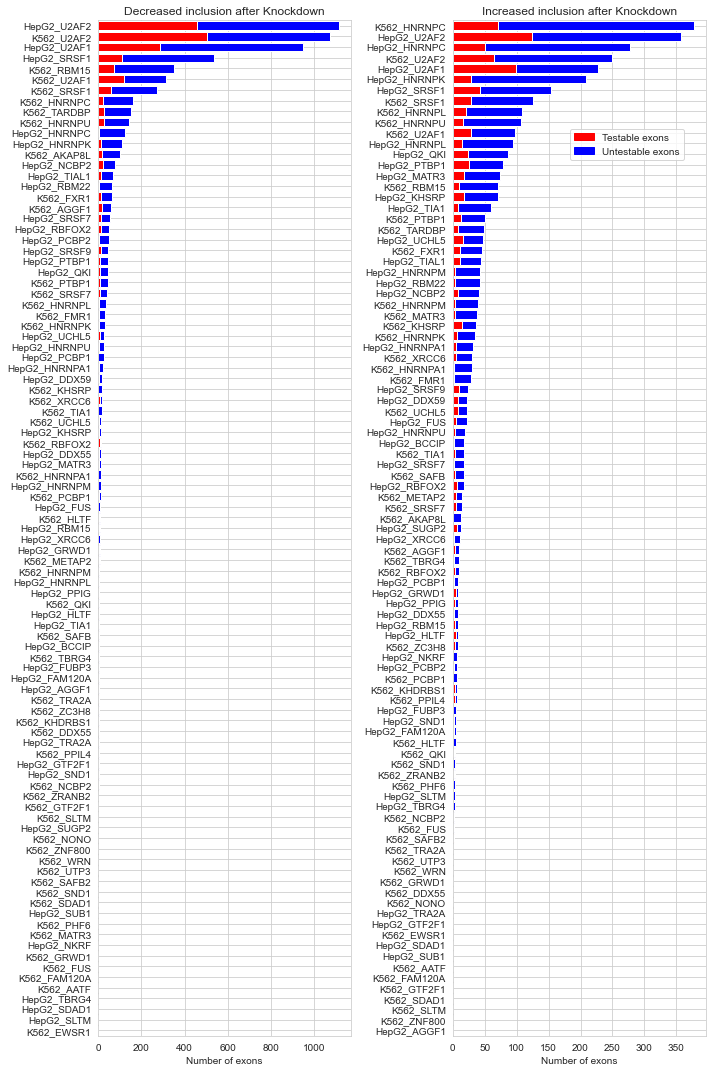

In [11]:
#QC check to make sure that testable exons (<101 nts) generally the distribution of overall exons
sensitive_exon_count_df = pd.read_csv(base_dir + 'preprocessed_data/SRE_number_testable.tsv', sep = '\t')

def peak_histogram(df, axis, title):
    ind = range(df.shape[0])
    labels = df.loc[:,'dataset']
    axis.barh(ind, width = df.loc[:,'total_number'], color = 'red')
    axis.barh(ind, width = df.loc[:,'total_number'] - df.loc[:,'testable_number'], left = df.loc[:,'testable_number'],
              color = 'blue')
    axis.set_yticks(ind)
    axis.set_yticklabels(labels)
    axis.set_title(title)
    axis.set_ylim(-0.5, max(ind)+0.5)
    axis.set_xlabel('Number of exons')
    return axis


sensitive_exon_count_down_df = sensitive_exon_count_df[sensitive_exon_count_df.loc[:,'direction'] == 'down'].sort_values('total_number').reset_index()
sensitive_exon_count_up_df = sensitive_exon_count_df[sensitive_exon_count_df.loc[:,'direction'] == 'up'].sort_values('total_number').reset_index()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,15))
ax1 = peak_histogram(sensitive_exon_count_down_df, ax1, 'Decreased inclusion after Knockdown')
ax2 = peak_histogram(sensitive_exon_count_up_df, ax2, 'Increased inclusion after Knockdown')

legend_TN = [patches.Patch(color = 'red', label = 'Testable exons'), patches.Patch(color = 'blue', label = 'Untestable exons')]
l2 = fig.legend(loc = (.8,.85), handles=legend_TN, frameon=True)

plt.tight_layout()

#plt.savefig(figure_out_dir + 'Supplemental_Figure_1_testable_SRE_histogram.svg')
#plt.savefig(figure_out_dir + 'Supplemental_Figure_1_testable_SRE_histogram.png')

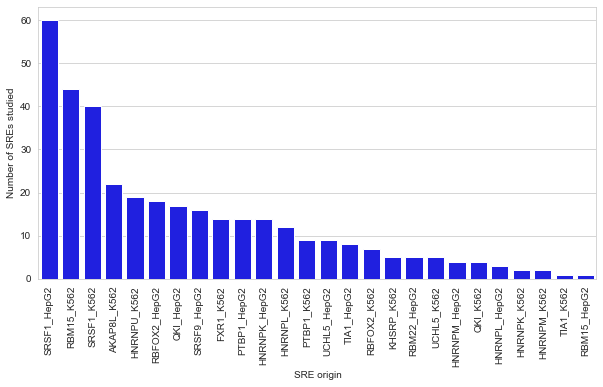

In [12]:
#showing which datasets we are using exons from
SRE_df = pd.read_csv(base_dir +'preprocessed_data/SRE_pool_sequences_dups_hg19.tsv', sep = '\t')

unique_events = list(set(SRE_df.loc[:,'control']))
event_origins = {}
for event in unique_events:
    origin = event.split('|')[0]
    if origin not in event_origins:
        event_origins[origin] = 0
    event_origins[origin] +=1

event_origins_df = pd.DataFrame({'SRE origin': list(event_origins.keys()), 'Frequency': list(event_origins.values())}).sort_values(by = 'Frequency', ascending = False)
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='SRE origin', y = 'Frequency', data = event_origins_df, color = 'blue', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Number of SREs studied')

#plt.savefig(figure_out_dir + 'Figure_2B_SRE_sources.svg', bbox_inches='tight')
plt.show()